<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>
Figure 1.1.a. Jupyter environment + Python notebooks

### Digital Earth Pacific Notebook 1 prepare postcard and load data to csv

The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe.

Step 1.1

In [1]:
# Predefined variable for title and version
version = "site_rf_08052025"  # Replace this with the variable you want to use

In [2]:
from pystac_client import Client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import rasterio as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import folium
import utils
# from utils import apply_masks
from utils import scale
from utils import calculate_band_indices
from utils import load_data
# from utils import mask_deeps_stumpf
# from utils import mask_deeps_ln_bg
# from utils import mask_deeps
# from utils import do_prediction 
# from utils import mask_and_scale
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import odc.geo.xr
import rioxarray
import matplotlib.pyplot as plt
import joblib
from shapely.geometry import box

Define catalogue

In [3]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [4]:
gdf = gpd.read_file("training-data/tulagi.geojson")
gdf = gdf.to_crs("EPSG:4326")
min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
bbox = [min_lon, min_lat, max_lon, max_lat]

In [5]:
min_lon = 160.08855
min_lat = -9.12915
max_lon = 160.17137
max_lat = -9.08003

bbox = [min_lon, min_lat, max_lon, max_lat]

In [6]:
datetime="2024"
items = list(client.search(collections=["dep_s2_geomad"], datetime=datetime, bbox=bbox).items())

In [7]:
from pystac import Collection

In [8]:
collection = Collection.from_file("https://stac.digitalearthpacific.org/collections/dep_s2_geomad")

In [9]:
data = load(
        items,
        measurements=[
            "nir", "red", "blue", "green", "emad", "smad", 
            "bcmad", "count", "green", "nir08", 
            "nir09", "swir16", "swir22", "coastal",
            "rededge1", "rededge2", "rededge3", 
        ],
        bbox=bbox,
        chunks={"x": 2048, "y": 2048},
        groupby="solar_day",
    )

In [10]:
# dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')
# configure_s3_access(cloud_defaults=True, requester_pays=True)

In [11]:
scaled = (data.where(data != 0) * 0.0001).clip(0, 1)

In [12]:
mndwi = (scaled["green"]-scaled["swir16"])/(scaled["green"]+scaled["swir16"])
## Moderate land mask
# mndwi_land_mask = mndwi > 0
mndwi_land_mask = mndwi > -1.5
clipped_ds = scaled.where(mndwi_land_mask)

In [13]:
ndti = (clipped_ds["red"]-clipped_ds["green"])/(clipped_ds["red"]+clipped_ds["green"])
ndti_mask = ndti < 0.2
clipped_ds = clipped_ds.where(ndti_mask)

In [14]:
nir = clipped_ds['nir']

# Moderate land mask
# nir_mask = nir < 0.085

# Conservative land mask
nir_mask = nir < 0.8
clipped_ds = clipped_ds.where(nir_mask)

In [15]:
# Incorporate other band ratios and indices
cai = (clipped_ds["coastal"]-clipped_ds["blue"])/( clipped_ds["coastal"]+ clipped_ds["blue"]) #coastal aerosol index
ndvi = (clipped_ds["nir"]-clipped_ds["red"])/( clipped_ds["nir"]+ clipped_ds["red"]) #vegetation index (NDVI)
evi = ((2.5*clipped_ds["nir"]-clipped_ds["red"])/(clipped_ds["nir"]+(6*clipped_ds["red"])-(7.5*clipped_ds["blue"])+1)) # enhanced vegetation index
savi = (clipped_ds["nir"]-clipped_ds["red"])/(clipped_ds["nir"]+clipped_ds["red"]) # soil adjusted vegetation index
ndwi = (clipped_ds["green"]-clipped_ds["nir"])/(clipped_ds["green"]+clipped_ds["nir"]+0.428)*(1+0.428) #water index (NDWI)
b_g = (clipped_ds["blue"])/(clipped_ds["green"]) #blue to green ratio
b_r = (clipped_ds["blue"])/(clipped_ds["red"]) #blue to red ratio
mci = (clipped_ds["nir"])/(clipped_ds["rededge1"]) # max chlorophlyll index (MCI)
ndci = (clipped_ds["rededge1"]-clipped_ds["red"])/(clipped_ds["rededge1"]+clipped_ds["red"]) # normalised difference chlorophyll index (NDCI)


In [16]:
clipped_ds['cai'] = cai
clipped_ds['ndvi'] = ndvi
clipped_ds['evi'] = evi
clipped_ds['savi'] = savi
clipped_ds['ndwi'] = ndwi
clipped_ds['mndwi'] = mndwi
clipped_ds['ndti'] = ndti
clipped_ds['b_g'] = b_g
clipped_ds['b_r'] = b_r
clipped_ds['mci'] = mci
clipped_ds['ndci'] = ndci

# clipped_ds

In [17]:
# Natural log of blue/green
clipped_ds["ln_bg"] = np.log(clipped_ds.blue / clipped_ds.green)
bg = clipped_ds["ln_bg"]
# conservative deep sea mask
mask_bg = bg < 0.0000001

In [18]:
all_masks = (mndwi_land_mask+ndti_mask+nir_mask+mask_bg)

In [19]:
# # add an epsilon 
# epsilon = 1e-6

# # additional indices from SDB (Alex)*

# # Calculate the stumpf index safely
# clipped_ds['stumpf'] = np.log(np.abs(clipped_ds.green - clipped_ds.blue)) / np.log(
#     clipped_ds.green + clipped_ds.blue + epsilon
# )

# # Define stumpf as a variable
# stumpf = clipped_ds['stumpf']

# # Mask out infinite or near-infinite values
# stumpf_cleaned = stumpf.where(np.isfinite(stumpf))  # Keeps only finite values

# # Optionally, remove very large values (e.g., threshold at 2.0)
# stumpf_cleaned = stumpf_cleaned.where(stumpf_cleaned < 100.0)

# # Replace the cleaned stumpf index back in the dataset
# clipped_ds['stumpf'] = stumpf_cleaned

# # Define mask
# stumpf = clipped_ds['stumpf']
# mask_stumpf = stumpf < 2.0


In [20]:
# all_masks = (mndwi_land_mask+ndti_mask+nir_mask+mask_bg+mask_stumpf)

### Postcard csv

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [21]:
# Define training data
gdf = gpd.read_file("training-data/tulagi.geojson")
gdf = gdf.to_crs("EPSG:4326")
# gdf.explore(column="cc_id", legend=True)

In [22]:
postcard = clipped_ds#.where(all_masks)
# postcard =clipped_ds.to_array(dim="band")
# First transform the training points to the same CRS as the data
training = gdf.to_crs(postcard.odc.geobox.crs)

In [23]:
print(training.columns)
training=training.drop(columns=['date', 'uuid'])

Index(['uuid', 'cc_id', 'observed', 'date', 'Surveyor', 'geometry'], dtype='object')


In [24]:
training

,cc_id,observed,Surveyor,geometry
0,10,land,AVK,POINT (1107765.244 -1048374.478)
1,10,land,AVK,POINT (1129310.605 -1010457.751)
2,10,land,AVK,POINT (1126087.375 -1010626.579)
3,10,land,AVK,POINT (1126043.267 -1010756.245)
4,10,land,AVK,POINT (1126090.193 -1010630.419)
...,...,...,...,...
2416,2,sand,AA,POINT (1126027.336 -1010376.136)
2417,6,coral,AA,POINT (1130284.129 -1013106.775)
2418,6,coral,AA,POINT (1130210.934 -1013163.929)
2419,2,sand,AA,POINT (1130346.83 -1012805.688)


In [25]:
training_da = training.assign(x=training.geometry.x, y=training.geometry.y).to_xarray()

In [26]:
training_values = (
    postcard.sel(training_da[["x", "y"]], method="nearest").squeeze().compute().to_pandas()
)
training_values

,nir,red,blue,green,emad,smad,bcmad,count,nir08,nir09,...,evi,savi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,ln_bg
index,,,,,,,,,,,,,,,,,,,,,
0,0.0234,0.0264,0.0444,0.0329,0.061656,5.143684e-06,0.000030,0.0051,0.0247,0.0408,...,0.037818,-0.060241,0.028012,0.187726,-0.109612,1.349544,1.681818,0.838710,0.027624,0.299767
1,0.3442,0.0486,0.0439,0.0852,0.084746,5.747080e-08,0.000005,0.0049,0.4106,0.4249,...,0.621408,0.752546,-0.431365,-0.405443,-0.273543,0.515258,0.903292,2.456816,0.484897,-0.663087
2,0.3592,0.0413,0.0413,0.0632,0.085095,1.138836e-07,0.000005,0.0048,0.4280,0.3780,...,0.660397,0.793758,-0.497046,-0.434958,-0.209569,0.653481,1.000000,3.504390,0.425591,-0.425442
3,0.3625,0.0341,0.0386,0.0622,0.093824,1.057208e-07,0.000006,0.0046,0.4145,0.4030,...,0.682647,0.828038,-0.502907,-0.503393,-0.291796,0.620579,1.131965,3.230838,0.533835,-0.477103
4,0.3899,0.0347,0.0377,0.0601,0.090945,1.162171e-07,0.000005,0.0046,0.4244,0.3325,...,0.714677,0.836552,-0.536395,-0.451892,-0.267932,0.627288,1.086455,3.918593,0.482861,-0.466350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416,0.3017,0.1158,0.0857,0.1175,0.110313,2.697021e-07,0.000007,0.0040,0.3490,0.3437,...,0.471616,0.445269,-0.310479,-0.339331,-0.007287,0.729362,0.740069,1.592925,0.241153,-0.315585
2417,0.0221,0.0399,0.0887,0.0982,0.069246,3.443748e-06,0.000024,0.0044,0.0232,0.0461,...,0.025744,-0.287097,0.198196,0.658784,-0.422158,0.903259,2.223058,0.583113,-0.025707,-0.101746
2418,0.0285,0.0331,0.0802,0.0769,0.090553,4.382574e-06,0.000030,0.0045,0.0323,0.0547,...,0.060981,-0.074675,0.129575,0.467557,-0.398182,1.042913,2.422961,0.818965,0.025037,0.042018


In [27]:
# Join the training data with the extracted values and remove unnecessary columns
training_array = pd.concat([training["cc_id"], training_values], axis=1)
# Drop rows where there was no data available
training_array = training_array.dropna()
# Preview our resulting training array
training_array.head()

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,evi,savi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,ln_bg
0,10,0.0234,0.0264,0.0444,0.0329,0.061656,5.143684e-06,0.000030,0.0051,0.0247,...,0.037818,-0.060241,0.028012,0.187726,-0.109612,1.349544,1.681818,0.838710,0.027624,0.299767
1,10,0.3442,0.0486,0.0439,0.0852,0.084746,5.747080e-08,0.000005,0.0049,0.4106,...,0.621408,0.752546,-0.431365,-0.405443,-0.273543,0.515258,0.903292,2.456816,0.484897,-0.663087
2,10,0.3592,0.0413,0.0413,0.0632,0.085095,1.138836e-07,0.000005,0.0048,0.4280,...,0.660397,0.793758,-0.497046,-0.434958,-0.209569,0.653481,1.000000,3.504390,0.425591,-0.425442
3,10,0.3625,0.0341,0.0386,0.0622,0.093824,1.057208e-07,0.000006,0.0046,0.4145,...,0.682647,0.828038,-0.502907,-0.503393,-0.291796,0.620579,1.131965,3.230838,0.533835,-0.477103
4,10,0.3899,0.0347,0.0377,0.0601,0.090945,1.162171e-07,0.000005,0.0046,0.4244,...,0.714677,0.836552,-0.536395,-0.451892,-0.267932,0.627288,1.086455,3.918593,0.482861,-0.466350


### Notebook 2 - Train Random Forest Machine Learning (ML) Model

Combine the csv geodataframes from notebook 1 into a single csv to train the machine learning model

Step 2.1. Concatenating all postcard dataframes

In [28]:
postcard_df = training_array
postcard_df.columns

Index(['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1',
       'rededge2', 'rededge3', 'y', 'x', 'spatial_ref', 'time', 'cai', 'ndvi',
       'evi', 'savi', 'ndwi', 'mndwi', 'ndti', 'b_g', 'b_r', 'mci', 'ndci',
       'ln_bg'],
      dtype='object')

In [29]:
postcard_df.columns

Index(['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1',
       'rededge2', 'rededge3', 'y', 'x', 'spatial_ref', 'time', 'cai', 'ndvi',
       'evi', 'savi', 'ndwi', 'mndwi', 'ndti', 'b_g', 'b_r', 'mci', 'ndci',
       'ln_bg'],
      dtype='object')

In [30]:
# postcard_df.columns
# postcard_df = postcard_df.drop(columns=["spatial_ref", "time", "field_1", "y", "x"])
# postcard_df = postcard_df.drop(columns=["field_1"])
postcard_df = postcard_df.drop(columns=["y", "x", "spatial_ref"])
postcard_df = postcard_df.drop(columns=["time"])
postcard_df

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,evi,savi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,ln_bg
0,10,0.0234,0.0264,0.0444,0.0329,0.061656,5.143684e-06,0.000030,0.0051,0.0247,...,0.037818,-0.060241,0.028012,0.187726,-0.109612,1.349544,1.681818,0.838710,0.027624,0.299767
1,10,0.3442,0.0486,0.0439,0.0852,0.084746,5.747080e-08,0.000005,0.0049,0.4106,...,0.621408,0.752546,-0.431365,-0.405443,-0.273543,0.515258,0.903292,2.456816,0.484897,-0.663087
2,10,0.3592,0.0413,0.0413,0.0632,0.085095,1.138836e-07,0.000005,0.0048,0.4280,...,0.660397,0.793758,-0.497046,-0.434958,-0.209569,0.653481,1.000000,3.504390,0.425591,-0.425442
3,10,0.3625,0.0341,0.0386,0.0622,0.093824,1.057208e-07,0.000006,0.0046,0.4145,...,0.682647,0.828038,-0.502907,-0.503393,-0.291796,0.620579,1.131965,3.230838,0.533835,-0.477103
4,10,0.3899,0.0347,0.0377,0.0601,0.090945,1.162171e-07,0.000005,0.0046,0.4244,...,0.714677,0.836552,-0.536395,-0.451892,-0.267932,0.627288,1.086455,3.918593,0.482861,-0.466350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416,2,0.3017,0.1158,0.0857,0.1175,0.110313,2.697021e-07,0.000007,0.0040,0.3490,...,0.471616,0.445269,-0.310479,-0.339331,-0.007287,0.729362,0.740069,1.592925,0.241153,-0.315585
2417,6,0.0221,0.0399,0.0887,0.0982,0.069246,3.443748e-06,0.000024,0.0044,0.0232,...,0.025744,-0.287097,0.198196,0.658784,-0.422158,0.903259,2.223058,0.583113,-0.025707,-0.101746
2418,6,0.0285,0.0331,0.0802,0.0769,0.090553,4.382574e-06,0.000030,0.0045,0.0323,...,0.060981,-0.074675,0.129575,0.467557,-0.398182,1.042913,2.422961,0.818965,0.025037,0.042018
2419,2,0.0291,0.0423,0.0976,0.1050,0.074694,3.343284e-06,0.000021,0.0047,0.0312,...,0.055273,-0.184874,0.192822,0.598174,-0.425662,0.929524,2.307328,0.606250,0.063123,-0.073083


In [31]:
len(postcard_df.columns)

29

In [51]:
joined_df = pd.read_csv("training-data/joined_training_data_11042025_test.csv")
joined_df.columns

Index(['Unnamed: 0', 'cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad',
       'bcmad', 'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal',
       'rededge1', 'rededge2', 'rededge3', 'cai', 'ndvi', 'ndwi', 'mndwi',
       'ndti', 'b_g', 'b_r', 'mci', 'ndci', 'y', 'x'],
      dtype='object')

In [53]:
joined_df = joined_df.drop(columns=["Unnamed: 0"])
joined_df.columns

Index(['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1',
       'rededge2', 'rededge3', 'cai', 'ndvi', 'ndwi', 'mndwi', 'ndti', 'b_g',
       'b_r', 'mci', 'ndci', 'y', 'x'],
      dtype='object')

In [54]:
correlation_matrix = joined_df.corr()

# Display the matrix
print(correlation_matrix)

             cc_id       nir       red      blue     green      emad  \
cc_id     1.000000  0.251314  0.191743  0.196799  0.198334  0.338373   
nir       0.251314  1.000000  0.719140  0.435462  0.507866  0.800955   
red       0.191743  0.719140  1.000000  0.857162  0.928126  0.621408   
blue      0.196799  0.435462  0.857162  1.000000  0.963797  0.541867   
green     0.198334  0.507866  0.928126  0.963797  1.000000  0.517382   
emad      0.338373  0.800955  0.621408  0.541867  0.517382  1.000000   
smad     -0.263010 -0.525267 -0.649557 -0.609282 -0.636978 -0.412608   
bcmad    -0.000468 -0.232421 -0.498055 -0.367957 -0.496034  0.177283   
count    -0.109710 -0.349274 -0.492707 -0.316153 -0.467422 -0.111915   
nir08     0.281652  0.942935  0.668800  0.433399  0.486698  0.830376   
nir09     0.108424  0.663542  0.431132  0.242825  0.274995  0.566750   
swir16    0.383256  0.793337  0.601835  0.508957  0.507362  0.865964   
swir22    0.408891  0.746193  0.569726  0.519196  0.499119  0.87

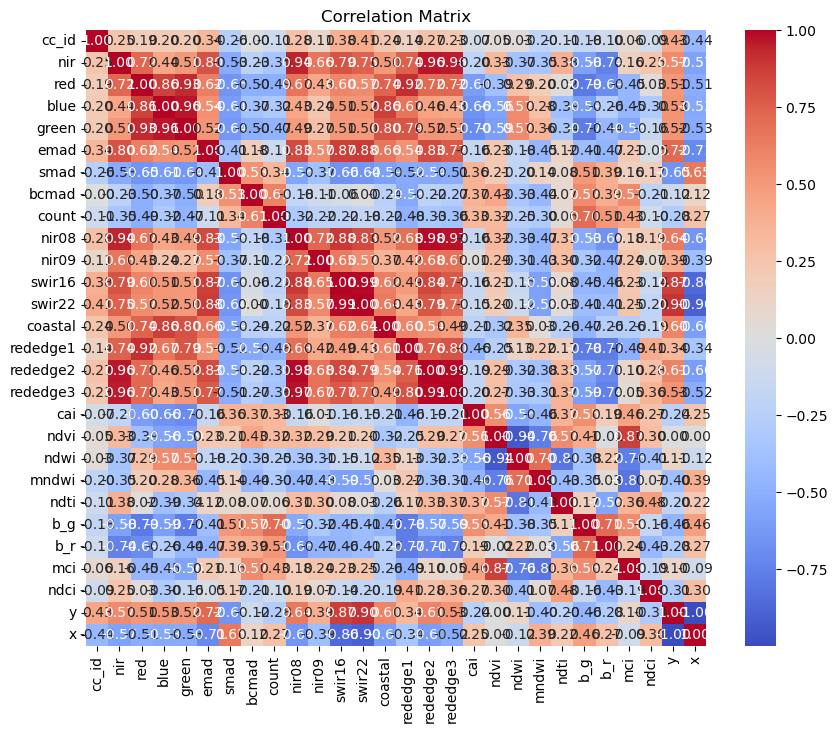

In [55]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [57]:
threshold = 0.8
high_corr = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix != 1.0)]
print(high_corr)

          cc_id       nir       red      blue     green      emad  smad  \
cc_id       NaN       NaN       NaN       NaN       NaN       NaN   NaN   
nir         NaN       NaN       NaN       NaN       NaN  0.800955   NaN   
red         NaN       NaN       NaN  0.857162  0.928126       NaN   NaN   
blue        NaN       NaN  0.857162       NaN  0.963797       NaN   NaN   
green       NaN       NaN  0.928126  0.963797       NaN       NaN   NaN   
emad        NaN  0.800955       NaN       NaN       NaN       NaN   NaN   
smad        NaN       NaN       NaN       NaN       NaN       NaN   NaN   
bcmad       NaN       NaN       NaN       NaN       NaN       NaN   NaN   
count       NaN       NaN       NaN       NaN       NaN       NaN   NaN   
nir08       NaN  0.942935       NaN       NaN       NaN  0.830376   NaN   
nir09       NaN       NaN       NaN       NaN       NaN       NaN   NaN   
swir16      NaN       NaN       NaN       NaN       NaN  0.865964   NaN   
swir22      NaN       NaN

In [58]:
high_corr.to_csv(f"{version}_high_correlation_matrix.csv")

Step 2.2. Train the ML model

In [32]:
# The classes are the first column
classes = np.array(postcard_df)[:, 0]

# The observation data is everything after the second column
observations = np.array(postcard_df)[:, 1:]

# Create a model...
classifier = RandomForestClassifier()

# ...and fit it to the data
model = classifier.fit(observations, classes)

In [33]:
# Dynamically create the filename with f-string
file_path = f"models/{version}-test.model"

# Save the model
joblib.dump(model, file_path)

['models/site_rf_08052025-test.model']

In [34]:
postcard_params = postcard_df.columns[1:]
print(postcard_params)

Index(['nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad', 'count',
       'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1', 'rededge2',
       'rededge3', 'cai', 'ndvi', 'evi', 'savi', 'ndwi', 'mndwi', 'ndti',
       'b_g', 'b_r', 'mci', 'ndci', 'ln_bg'],
      dtype='object')


In [35]:
importances = classifier.feature_importances_

# Create the DataFrame
data = {
    'param': postcard_params,  # Use the list directly
    'importance': importances,  # Use the list directly
}
importance_df = pd.DataFrame(data)

importance_df["%"] = (importance_df["importance"]*100)

sorted_df = importance_df.sort_values(by='importance', ascending=False)
sorted_df.to_csv(f"{version}importance_df.csv")

In [36]:
sorted_df

,param,importance,%
27,ln_bg,0.082260,8.226028
3,green,0.065829,6.582866
23,b_g,0.053115,5.311470
2,blue,0.046177,4.617690
6,bcmad,0.045540,4.553978
13,rededge1,0.045231,4.523061
24,b_r,0.041329,4.132867
7,count,0.039180,3.917984
9,nir09,0.038645,3.864522
20,ndwi,0.037880,3.788048


In [37]:
postcard


<xarray.Dataset> Size: 57MB
Dimensions:      (time: 1, y: 551, x: 923)
Coordinates:
  * y            (y) float64 4kB -1.008e+06 -1.008e+06 ... -1.014e+06 -1.014e+06
  * x            (x) float64 7kB 1.123e+06 1.123e+06 ... 1.132e+06 1.132e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/28)
    nir          (time, y, x) float32 2MB dask.array<chunksize=(1, 551, 923), meta=np.ndarray>
    red          (time, y, x) float32 2MB dask.array<chunksize=(1, 551, 923), meta=np.ndarray>
    blue         (time, y, x) float32 2MB dask.array<chunksize=(1, 551, 923), meta=np.ndarray>
    green        (time, y, x) float32 2MB dask.array<chunksize=(1, 551, 923), meta=np.ndarray>
    emad         (time, y, x) float32 2MB dask.array<chunksize=(1, 551, 923), meta=np.ndarray>
    smad         (time, y, x) float32 2MB dask.array<chunksize=(1, 551, 923), meta=np.ndarray>
    ...           ...
    ndti         (time, y, x) float32 2MB dask.array<chunksize=(1, 551, 923), meta=np.ndarray>
    b_g          (time, y, x) float32 2MB dask.array<chunksize=(1, 551, 923), meta=np.ndarray>
    b_r          (time, y, x) float32 2MB dask.array<chunksize=(1, 551, 923), meta=np.ndarray>
    mci          (time, y, x) float32 2MB dask.array<chunksize=(1, 551, 923), meta=np.ndarray>
    ndci         (time, y, x) float32 2MB dask.array<chunksize=(1, 551, 923), meta=np.ndarray>
    ln_bg        (time, y, x) float32 2MB dask.array<chunksize=(1, 551, 923), meta=np.ndarray>

In [38]:
# Convert to a stacked array of observations
# stacked_arrays = stacked_arrays.squeeze()
stacked_arrays = postcard.squeeze()#.stack(dims=["y", "x"])#.transpose()
stacked_arrays = stacked_arrays.to_dataarray()

In [39]:
stacked_arrays

<xarray.DataArray (variable: 28, y: 551, x: 923)> Size: 57MB
dask.array<stack, shape=(28, 551, 923), dtype=float32, chunksize=(1, 551, 923), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4kB -1.008e+06 -1.008e+06 ... -1.014e+06 -1.014e+06
  * x            (x) float64 7kB 1.123e+06 1.123e+06 ... 1.132e+06 1.132e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
  * variable     (variable) object 224B 'nir' 'red' 'blue' ... 'ndci' 'ln_bg'

In [40]:
# stacked_arrays_2d

In [41]:
stacked_arrays_2d = stacked_arrays.stack(new_dim=("y", "x")) 

In [42]:
reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')

In [43]:
# stacked_arrays = stacked_arrays.reshape(-1, 26)
stacked_arrays_2d.shape


(28, 508573)

In [44]:
# Convert to a stacked array of observations
# stacked_arrays_2d = stacked_arrays_2d.to_array().stack(dims=["y", "x"])

# Replace any infinities with NaN
stacked_arrays_2d = stacked_arrays_2d.where(stacked_arrays_2d != float("inf"))
stacked_arrays_2d = stacked_arrays_2d.where(stacked_arrays_2d != float("-inf"))

# Replace any NaN values with 0
df = stacked_arrays_2d.squeeze().fillna(0).transpose().to_pandas()

# Remove the all-zero rows
zero_mask = (df == 0).all(axis=1)  # Creates a boolean Series
non_zero_df = df.loc[~zero_mask]  # Filters out all-zero rows

# Create a new array to hold the predictions
full_pred = pd.Series(np.nan, index=df.index)

reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')

In [45]:
# Predict the classes

predicted = model.predict(reordered_data_array)


In [46]:

# Reshape back to the original 2D array
reordered_data_array = predicted.reshape(len(postcard.y), len(postcard.x))

# Convert to an xarray again, because it's easier to work with
predicted_da = xr.DataArray(
    reordered_data_array, coords={"y": postcard.y, "x": postcard.x}, dims=["y", "x"]
)

In [47]:
print(predicted_da.dtype)  # Check the dtype of your DataArray
predicted_da = predicted_da.astype('float32')  # Convert to float32

# Check for NaN values
if np.isnan(predicted_da).any():
    print("NaN values found in the data")
    # Handle NaN values, e.g. by filling them
    predicted_da = predicted_da.fillna(0)  # Replace NaN with 0 or appropriate value

float64


In [48]:
predicted_da

<xarray.DataArray (y: 551, x: 923)> Size: 2MB
array([[ 8.,  8.,  8., ..., 10., 10., 10.],
       [ 8.,  8.,  8., ..., 10., 10., 10.],
       [ 8.,  8.,  8., ..., 10., 10., 10.],
       ...,
       [ 8.,  8.,  8., ...,  8.,  8.,  8.],
       [ 8.,  8.,  8., ...,  8.,  8.,  8.],
       [ 8.,  8.,  8., ...,  8.,  8.,  8.]], dtype=float32)
Coordinates:
  * y        (y) float64 4kB -1.008e+06 -1.008e+06 ... -1.014e+06 -1.014e+06
  * x        (x) float64 7kB 1.123e+06 1.123e+06 ... 1.132e+06 1.132e+06

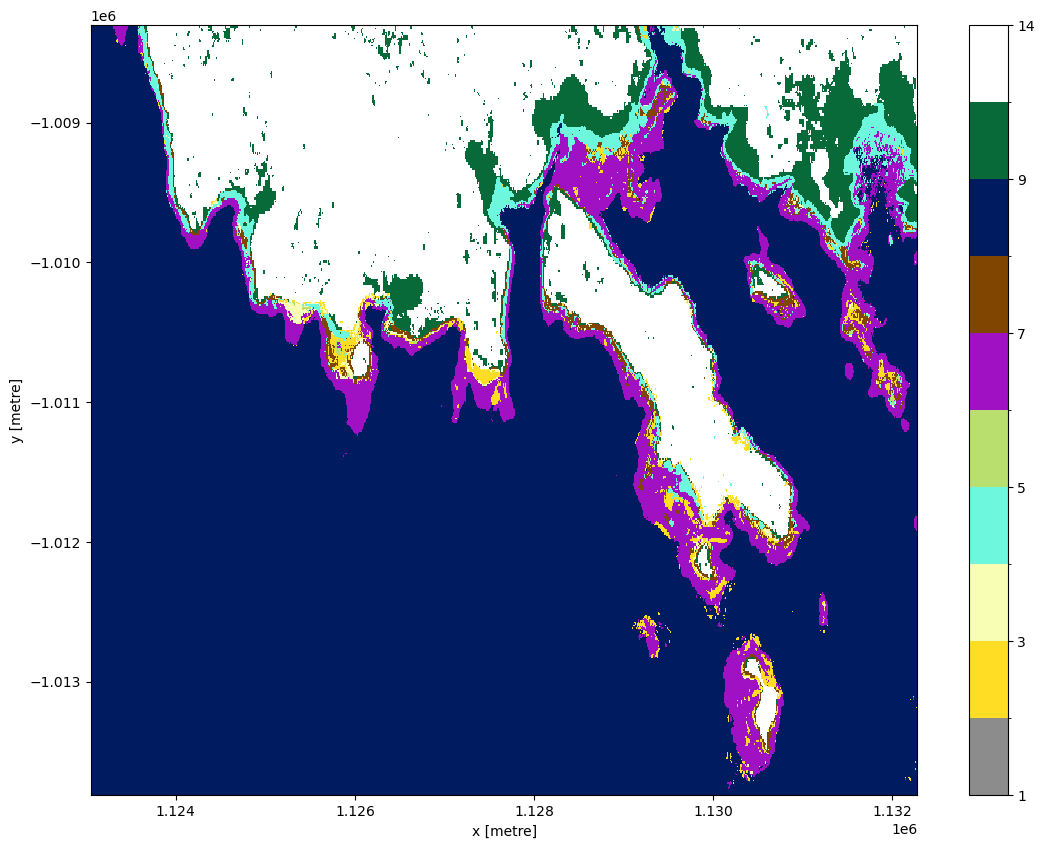

In [49]:
from matplotlib import colors

classes = [
    [1, "sediment", "#8c8c8c"],
    [2, "sand", "#fedd24"],
    [3, "rubble", "#f8ffb4"],
    [4, "seagrass", "#6df7dc"],
    [5, "seaweed", "#b9df6f"],
    [6, "coral", "#a011c3"],
    [7, "rock", "#804600"],
    [8, "deeps", "#011b61"],
    [9, "mangrove", "#086a39"],
    [10, "land", "#ffffff"],
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [14]
norm = colors.BoundaryNorm(bounds, c_map.N)

predicted_da.plot.imshow(cmap=c_map, norm=norm, size=10)

In [50]:
predicted_da.odc.explore()

In [51]:
# issue where not all masks are being included - only land but not surf / also strange effect on side
predicted_da = predicted_da.where(all_masks)

In [52]:
predicted_da.odc.explore(cmap=c_map)

In [53]:
# issue where not all masks are being included - only land but not surf / also strange effect on side
predicted_da = predicted_da.where(bg < 0.2)
predicted_da.odc.explore(cmap=c_map)

In [54]:
predicted_da.odc.write_cog(f"{version}.tiff", overwrite=True)

PosixPath('site_rf_08052025.tiff')